# Random forest classifier for all-beta structures

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
%matplotlib inline
sns.set()

Functions

In [2]:
def define_dict(dict_vals):
    aa_dict =  {'A': dict_vals[0],
                'R': dict_vals[1],
                'N': dict_vals[2],
                'D': dict_vals[3],
                'C': dict_vals[4],
                'Q': dict_vals[5],
                'E': dict_vals[6],
                'G': dict_vals[7],
                'H': dict_vals[8],
                'I': dict_vals[9],
                'L': dict_vals[10],
                'K': dict_vals[11],
                'M': dict_vals[12],
                'F': dict_vals[13],
                'P': dict_vals[14],
                'S': dict_vals[15],
                'T': dict_vals[16],
                'W': dict_vals[17],
                'Y': dict_vals[18],
                'V': dict_vals[19]}
    return aa_dict

In [3]:
def remove_nan(prop_list, vals_ignore):
    remove_list = ['', np.nan] + vals_ignore
    filtered_list = [val for val in prop_list if val not in remove_list]
    return filtered_list

In [4]:
def find_fasta(df, feature_name, nested_list=True):
    feature_list = df[feature_name].tolist()
    res_id_list = df['RES_ID'].tolist()
    fasta_list = ['']*len(feature_list)

    if nested_list is True:
        for index, feature_sub_list in enumerate(feature_list):
            fasta_sub_list = []
            for res_id in feature_sub_list:
                if res_id in res_id_list:
                    fasta = df['FASTA'].tolist()[res_id_list.index(res_id)]
                    fasta_sub_list.append(fasta)
            fasta_list[index] = fasta_sub_list
    elif nested_list is False:
        for index, res_id in enumerate(feature_list):
            if res_id in res_id_list:
                fasta = df['FASTA'].tolist()[res_id_list.index(res_id)]
                fasta_list[index] = fasta

    extra_column = pd.DataFrame({'{}_FASTA'.format(feature_name): fasta_list})
    df = df.reset_index(drop=True)
    df = pd.concat([df, extra_column], axis=1)
    return df

In [5]:
def one_hot_encode(df, feature_name, prefix='', nested_list=False, vals_ignore=[]):
    feature_list = df[feature_name].tolist()
    
    if nested_list is False:
        feature_set = remove_nan(list(set(feature_list)), vals_ignore)
    if nested_list is True:
        flattened_feature_list = [val for val_list in feature_list for val in val_list]
        feature_set = remove_nan(list(set(flattened_feature_list)), vals_ignore)

    one_hot_encode_dict = {}
    for feature in feature_set:
        one_hot_encode_dict['{}{}'.format(prefix, feature)] = [0]*len(feature_list)

    for index, val in enumerate(feature_list):
        if nested_list is False:
            if val in feature_set:
                one_hot_encode_dict['{}{}'.format(prefix, val)][index] += 1
        elif nested_list is True:
            for sub_val in val:
                if sub_val in feature_set:
                    one_hot_encode_dict['{}{}'.format(prefix, sub_val)][index] +=1

    return one_hot_encode_dict

In [6]:
def gen_train_test_data(features, labels, test_frac):
    all_features_df = pd.DataFrame({key: value for features_dict in features for key, value in
                                      features_dict.items()})
    all_labels_df = pd.DataFrame({key: value for labels_dict in labels for key, value in labels_dict.items()})
    feature_names = list(all_features_df.columns.values)
    label_names = list(all_labels_df.columns.values)

    train_features, test_features, train_labels, test_labels = train_test_split(
        all_features_df, all_labels_df, test_size=test_frac
    )

    return train_features, test_features, train_labels, test_labels, feature_names, label_names

In [7]:
def calc_feature_importances(model, feature_names):
    feature_importances = list(model.feature_importances_)
    feature_importances = pd.DataFrame({'FEATURE': feature_names,
                                        'IMPORTANCE': feature_importances})
    return feature_importances

In [8]:
def plot_feature_importances(feature_importances):
    plt.figure(figsize=(20, 10))
    plt.xlabel('Variable')
    plt.ylabel('Importance')
    plt.xticks(rotation=90)
    sns.barplot(feature_importances['FEATURE'], feature_importances['IMPORTANCE'])
    plt.show()

In [9]:
def calc_accuracy_r2(model, metric, test_features, test_labels):
    predictions = model.predict(test_features)
    score = metric(test_labels, predictions, )
    return predictions, score

In [10]:
def convert_aa_id_to_cont_property(neighbours_list, property_dict, label, nested_list=True):
    neighbours_summed_property = [0]*len(neighbours_list)

    if nested_list is True:
        for index, res_list in enumerate(neighbours_list):
            if len(res_list) > 0:
                for res in res_list:
                    if res in property_dict:
                        neighbours_summed_property[index] += property_dict[res]
                neighbours_summed_property[index] = neighbours_summed_property[index] / len(res_list)
    elif nested_list is False:
        for index, res in enumerate(neighbours_list):
            if res in property_dict:
                neighbours_summed_property[index] += property_dict[res]

    neighbours_summed_property_dict = {label: neighbours_summed_property}
    return(neighbours_summed_property_dict)

Define amino acid property dictionaries

In [11]:
aa_three_letter_code_list = ['Ala', 'Arg', 'Asn', 'Asp', 'Cys', 'Gln', 'Glu', 'Gly', 'His', 'Ile', 'Leu', 'Lys',
                             'Met', 'Phe', 'Pro', 'Ser', 'Thr', 'Trp', 'Tyr', 'Val']
aa_dict = define_dict(aa_three_letter_code_list)

In [12]:
# Average residue mass (Burlingame and Carr, 1996)
mass_list = [71.0788, 156.1876, 114.1039, 115.0886, 103.1448, 128.1308, 129.1155, 57.0520, 137.1412, 113.1595,
             113.1595, 128.1742, 131.1986, 147.1766, 97.1167, 87.0782, 101.1051, 186.2133, 163.1760, 99.1326]
mass_dict = define_dict(mass_list)

In [13]:
# Kyte and Doolittle scale
hydrophobicity_list = [1.8, -4.5, -3.5, -3.5, 2.5, -3.5, -3.5, -0.4, -3.2, 4.5, 3.8, -3.9, 1.9, 2.8, -1.6, -0.8,
                       -0.7, -0.9, -1.3, 4.2]
hydrophobicity_dict = define_dict(hydrophobicity_list)

In [14]:
# Side chain volume (Krigbaum-Komoriya, 1979)
side_chain_volume_list = [27.5, 105.0, 58.7, 40.0, 44.6, 80.7, 62.0, 0.0, 79.0, 93.5, 93.5, 100.0, 94.1, 115.5, 41.9,
                          29.3, 51.3, 145.5, 117.3, 71.5]
side_chain_volume_dict = define_dict(side_chain_volume_list)

In [15]:
# Side chain solvent accessible surface area (Miller et al, 1987)
side_chain_sasa_list = [67, 196, 113, 106, 104, 144, 138, 0, 151, 140, 137, 167, 160, 175, 105, 80, 102, 217, 187,
                        117]
side_chain_sasa = define_dict(side_chain_sasa_list)

In [16]:
# From pKa values of Cantor and Schimmel (1980)
"""
pka_dict = {'A': '',
            'R': 12,
            'N': '',
            'D': 4.5,
            'C': 8.65,
            'Q': '',
            'E': 4.5,
            'G': '',
            'H': 6.75,
            'I': '',
            'L': '',
            'K': 10.1,
            'M': '',
            'F': '',
            'P': '',
            'S': '',
            'T': '',
            'W': '',
            'Y': 9.8,
            'V': ''}
"""

charge_at_ph_7_list = [0, 1, 0, -1, -0.02, 0, -1, 0, 0.36, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
charge_at_ph_7_dict = define_dict(charge_at_ph_7_list)

In [17]:
posi_charge_at_ph_7_list = [0, 1, 0, 0, 0, 0, 0, 0, 0.36, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
posi_charge_at_ph_7_dict = define_dict(posi_charge_at_ph_7_list)

In [18]:
neg_charge_at_ph_7_list = [0, 0, 0, -1, -0.02, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
neg_charge_at_ph_7_dict = define_dict(neg_charge_at_ph_7_list)

In [19]:
# Mean polarity (Radzicka-Wolfenden, 1988)
polarity_list = [-0.06, -0.84, -0.48, -0.80, 1.36, -0.73, -0.77, -0.41, 0.49, 1.31, 1.21, -1.18, 1.27, 1.27, 0.0,
                 -0.50, -0.27, 0.88, 0.33,  1.09]
polarity_dict = define_dict(polarity_list)

In [20]:
# 1 = aromatic, 0 = not aromatic
aromaticity_list = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0]
aromaticity_dict = define_dict(aromaticity_list)

In [21]:
# Average flexibility indices in globular proteins (Bhaskaran-Ponnuswamy, 1988)
flexibility_list = [52.6, 109.1, 75.7, 68.4, 68.3, 89.7, 84.7, 36.3, 91.9, 102.0, 102.0, 105.1, 97.7, 113.9, 73.6,
                    54.9, 71.2, 135.4, 116.2, 85.1]
flexibility_dict = define_dict(flexibility_list)

### Beta_barrels

Prepare input data 

In [22]:
barrel_file_loc = input('Specify absolute file path of beta_barrels dataframe: ')

Specify absolute file path of beta_barrels dataframe: 


In [23]:
barrel_file_loc = '/Users/ks17361/Lab_work_DW/Beta_structure/Parametrisation/My_beta_sandwich_and_barrel_datasets/CATH_barrels_resn_2.5_rfac_0.3_40_alignment/Beta_res_dataframe.pkl'

In [24]:
barrel_df = pd.read_pickle(barrel_file_loc)

In [25]:
barrel_df['PHI'] = pd.to_numeric(barrel_df['PHI'])
barrel_df['PSI'] = pd.to_numeric(barrel_df['PSI'])
barrel_df['OMEGA'] = pd.to_numeric(barrel_df['OMEGA'])
barrel_df['Z_COORDS'] = pd.to_numeric(barrel_df['Z_COORDS'])
barrel_df['SOLV_ACSBLTY'] = pd.to_numeric(barrel_df['SOLV_ACSBLTY'])

In [26]:
barrel_df.head()

,STRAND_ID,TILT_ANGLE(DEGREES),TOTAL_STRAND_NUMBER,PARENT_STRAND_NUMBER,SHEAR_NUMBER,RES_ID,FASTA,Z_COORDS,STRAND_POS(%),INT_EXT,...,MINUS_2_POS,PLUS_2_POS,NEIGHBOURING_RESIDUES(<5.0A)_FASTA,BRIDGE_PAIRS_FASTA,VDW_FASTA,HBOND_FASTA,IONIC_FASTA,SSBOND_FASTA,PIPISTACK_FASTA,PICATION_FASTA
0,4dcbA00_strand_1,Undefined,14,1,,A32,Y,35.851,,exterior,...,M,A,"[M, L, D, G, R, K, A]",[I],"[M, L, D, K]",[A],[],[],[],[]
1,4dcbA00_strand_1,Undefined,14,1,,A31,L,34.967,,interior,...,E,D,"[M, Y, I, S, A]","[N, ]","[M, Y, I, S, P]","[I, S]",[],[],[],[]
2,4dcbA00_strand_1,Undefined,14,1,,A30,M,31.800,,exterior,...,H,Y,"[H, E, L, Y, S, Q, E, G]","[V, ]","[H, E, L, Y, K, Q, E]",[G],[],[],[],[]
3,4dcbA00_strand_1,Undefined,14,1,,A29,E,30.182,,interior,...,S,L,"[H, M, L, W, Y, D]","[A, ]","[H, M, Y]","[L, W]",[],[],[],[]
4,4dcbA00_strand_1,Undefined,14,1,,A28,H,27.116,,exterior,...,K,M,"[S, E, M, L, D, S]","[I, ]","[K, S, E, M, D]",[S],[],[],[],[]


In [27]:
barrel_df['PHI'].tolist()

[-135.3,
 -139.1,
 -116.8,
 -118.3,
 -132.2,
 -115.2,
 -156.7,
 160.8,
 -150.8,
 -117.2,
 -128.0,
 169.8,
 -128.5,
 -142.3,
 -143.3,
 -141.3,
 -123.3,
 -138.5,
 nan,
 -90.5,
 -103.5,
 -149.0,
 -149.1,
 -110.9,
 -100.8,
 -112.9,
 -96.5,
 -110.9,
 -84.3,
 -150.5,
 -130.8,
 -74.2,
 -125.9,
 -116.9,
 -123.2,
 -127.9,
 -151.0,
 -126.7,
 -133.1,
 -130.1,
 -103.9,
 -60.4,
 -137.7,
 -67.3,
 -148.4,
 -149.4,
 179.0,
 -141.5,
 -119.8,
 -137.6,
 -107.7,
 -122.4,
 56.7,
 -130.8,
 -114.6,
 -125.7,
 -128.9,
 -143.2,
 -158.5,
 -151.7,
 -97.0,
 157.0,
 66.5,
 -150.2,
 -125.4,
 -129.3,
 -133.7,
 -62.8,
 -86.5,
 -110.2,
 -101.9,
 -88.5,
 -62.7,
 -166.8,
 -155.0,
 -159.6,
 -150.8,
 -136.6,
 -148.6,
 -117.0,
 -150.8,
 -119.6,
 -128.0,
 -106.6,
 -86.7,
 -111.4,
 -132.9,
 -157.2,
 -127.8,
 -94.3,
 -131.9,
 -126.6,
 -136.0,
 -135.0,
 -134.0,
 -135.6,
 -139.5,
 -139.7,
 -116.6,
 -156.7,
 -144.4,
 -114.4,
 -106.7,
 -157.5,
 -140.0,
 -131.4,
 30.7,
 -118.9,
 -130.2,
 -146.5,
 -98.7,
 66.0,
 -134.3,
 164.8,
 -12

In [28]:
barrel_df_filt = barrel_df[barrel_df['FASTA'].isin(list(aa_dict.keys()))
                           & barrel_df['INT_EXT'].isin(['interior', 'exterior'])
                           & barrel_df['TM_OR_EXT'].isin(['external', 'transmembrane'])
                           & ~barrel_df['PHI'].isin(['nan'])
                           & ~barrel_df['PSI'].isin(['nan'])
                           & ~barrel_df['OMEGA'].isin(['nan'])
                           & ~barrel_df['Z_COORDS'].isin(['nan'])
                           & ~barrel_df['SOLV_ACSBLTY'].isin(['nan'])]
barrel_df_filt = barrel_df_filt.reset_index(drop=True)

In [29]:
barrel_df_filt['PHI'].tolist()

[-135.3,
 -139.1,
 -116.8,
 -118.3,
 -132.2,
 -115.2,
 -156.7,
 160.8,
 -150.8,
 -117.2,
 -128.0,
 169.8,
 -128.5,
 -142.3,
 -143.3,
 -141.3,
 -123.3,
 -138.5,
 -90.5,
 -103.5,
 -149.0,
 -149.1,
 -110.9,
 -100.8,
 -112.9,
 -96.5,
 -110.9,
 -84.3,
 -150.5,
 -130.8,
 -74.2,
 -125.9,
 -116.9,
 -123.2,
 -127.9,
 -151.0,
 -126.7,
 -133.1,
 -130.1,
 -103.9,
 -60.4,
 -137.7,
 -67.3,
 -148.4,
 -149.4,
 179.0,
 -141.5,
 -119.8,
 -137.6,
 -107.7,
 -122.4,
 56.7,
 -130.8,
 -114.6,
 -125.7,
 -128.9,
 -143.2,
 -158.5,
 -151.7,
 -97.0,
 157.0,
 66.5,
 -150.2,
 -125.4,
 -129.3,
 -133.7,
 -62.8,
 -86.5,
 -110.2,
 -101.9,
 -88.5,
 -62.7,
 -166.8,
 -155.0,
 -159.6,
 -150.8,
 -136.6,
 -148.6,
 -117.0,
 -150.8,
 -119.6,
 -128.0,
 -106.6,
 -86.7,
 -111.4,
 -132.9,
 -157.2,
 -127.8,
 -94.3,
 -131.9,
 -126.6,
 -136.0,
 -135.0,
 -134.0,
 -135.6,
 -139.5,
 -139.7,
 -116.6,
 -156.7,
 -144.4,
 -114.4,
 -106.7,
 -157.5,
 -140.0,
 -131.4,
 30.7,
 -118.9,
 -130.2,
 -146.5,
 -98.7,
 66.0,
 -134.3,
 164.8,
 -120.0,
 

In [216]:
barrel_df_filt.columns

Index(['STRAND_ID', 'TILT_ANGLE(DEGREES)', 'TOTAL_STRAND_NUMBER',
       'PARENT_STRAND_NUMBER', 'SHEAR_NUMBER', 'RES_ID', 'FASTA', 'Z_COORDS',
       'STRAND_POS(%)', 'INT_EXT', 'TM_OR_EXT', 'OMEGA', 'PHI', 'PSI',
       'CHI_ANGLES', 'SOLV_ACSBLTY', 'NEIGHBOURING_RESIDUES(<5.0A)',
       'BRIDGE_PAIRS', 'VDW', 'HBOND', 'IONIC', 'SSBOND', 'PIPISTACK',
       'PICATION', 'MINUS_1_POS', 'PLUS_1_POS', 'MINUS_2_POS', 'PLUS_2_POS',
       'NEIGHBOURING_RESIDUES(<5.0A)_FASTA', 'BRIDGE_PAIRS_FASTA', 'VDW_FASTA',
       'HBOND_FASTA', 'IONIC_FASTA', 'SSBOND_FASTA', 'PIPISTACK_FASTA',
       'PICATION_FASTA'],
      dtype='object')

In [31]:
barrel_int_ext = one_hot_encode(barrel_df_filt, 'INT_EXT')

In [32]:
barrel_tm_ext = one_hot_encode(barrel_df_filt, 'TM_OR_EXT')

In [33]:
barrel_neighbours = one_hot_encode(barrel_df_filt, 'NEIGHBOURING_RESIDUES(<5.0A)_FASTA', prefix='NEIGHBOUR_',
                                   nested_list=True, vals_ignore=['X'])

In [34]:
barrel_backbone_h = one_hot_encode(barrel_df_filt, 'BRIDGE_PAIRS_FASTA', prefix='BRIDGE_PAIRS_', nested_list=True,
                                   vals_ignore=['X'])

In [35]:
barrel_z = {'Z_COORDS': barrel_df_filt['Z_COORDS'].tolist()}
barrel_phi_psi_omega = {'PHI': barrel_df_filt['PHI'].tolist(),
                        'PSI': barrel_df_filt['PSI'].tolist(),
                        'OMEGA': barrel_df_filt['OMEGA'].tolist()}

In [36]:
barrel_fasta = one_hot_encode(barrel_df_filt, 'FASTA', prefix='FASTA_', vals_ignore=['X'])

In [37]:
(barrel_train_features_1, barrel_test_features_1, barrel_train_labels_1, barrel_test_labels_1, barrel_feature_names_1,
barrel_label_names_1) = gen_train_test_data(
    [barrel_int_ext, barrel_tm_ext, barrel_z, barrel_phi_psi_omega, barrel_backbone_h], [barrel_fasta], test_frac=0.25
)

Initialise and train random forest classifier

In [38]:
barrel_clf_1 = RandomForestClassifier(
    n_estimators=10, criterion='entropy'
)
barrel_clf_1.fit(barrel_train_features_1, barrel_train_labels_1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [39]:
barrel_feature_importances_1 = calc_feature_importances(barrel_clf_1, barrel_feature_names_1)

In [40]:
print(barrel_feature_importances_1)

           FEATURE  IMPORTANCE
0   BRIDGE_PAIRS_A    0.016211
1   BRIDGE_PAIRS_C    0.000152
2   BRIDGE_PAIRS_D    0.016769
3   BRIDGE_PAIRS_E    0.010541
4   BRIDGE_PAIRS_F    0.011604
5   BRIDGE_PAIRS_G    0.022802
6   BRIDGE_PAIRS_H    0.006042
7   BRIDGE_PAIRS_I    0.008770
8   BRIDGE_PAIRS_K    0.013235
9   BRIDGE_PAIRS_L    0.019042
10  BRIDGE_PAIRS_M    0.004807
11  BRIDGE_PAIRS_N    0.015102
12  BRIDGE_PAIRS_P    0.009426
13  BRIDGE_PAIRS_Q    0.010944
14  BRIDGE_PAIRS_R    0.012667
15  BRIDGE_PAIRS_S    0.016374
16  BRIDGE_PAIRS_T    0.017831
17  BRIDGE_PAIRS_V    0.015847
18  BRIDGE_PAIRS_W    0.008778
19  BRIDGE_PAIRS_Y    0.015657
20           OMEGA    0.151747
21             PHI    0.179214
22             PSI    0.184207
23        Z_COORDS    0.176230
24        exterior    0.014739
25        external    0.013153
26        interior    0.014616
27   transmembrane    0.013494


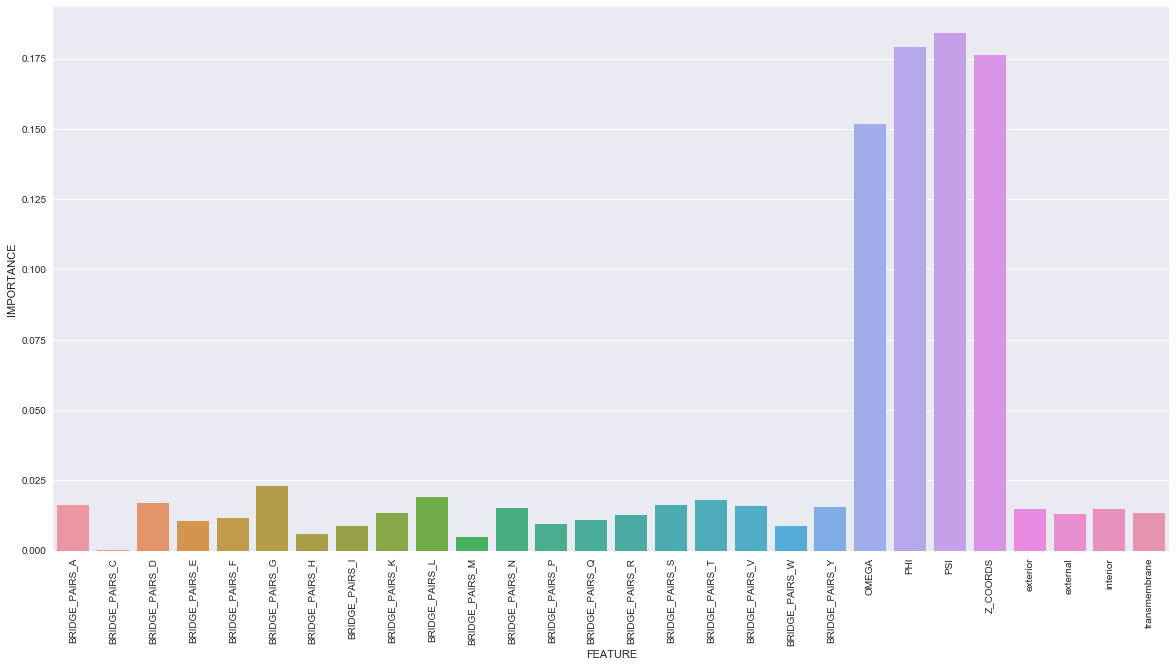

In [41]:
plot_feature_importances(barrel_feature_importances_1)

In [42]:
barrel_clf_1_predictions, barrel_clf_1_accuracy = calc_accuracy_r2(
    barrel_clf_1, accuracy_score, barrel_test_features_1, barrel_test_labels_1
)

In [43]:
print(barrel_clf_1_accuracy)

0.03720050441361917


### Beta_sandwiches

In [ ]:
sandwich_file_loc = input('Specify absolute file path of beta_sandwiches dataframe: ')

In [ ]:
sandwich_file_loc = '/Users/ks17361/Lab_work_DW/Beta_structure/Parametrisation/My_beta_sandwich_and_barrel_datasets/CATH_2.60.40.10_resn_1.6_rfac_0.2_40_alignment/Beta_res_dataframe.pkl'

In [ ]:
sandwich_df = pd.read_pickle(sandwich_file_loc)

In [ ]:
sandwich_df['PHI'] = pd.to_numeric(sandwich_df['PHI'])
sandwich_df['PSI'] = pd.to_numeric(sandwich_df['PSI'])
sandwich_df['OMEGA'] = pd.to_numeric(sandwich_df['OMEGA'])
sandwich_df['STRAND_POS(ABS)'] = pd.to_numeric(sandwich_df['STRAND_POS(ABS)'])
sandwich_df['STRAND_POS(%)'] = pd.to_numeric(sandwich_df['STRAND_POS(%)'])
sandwich_df['BURIED_SURFACE_AREA(%)'] = pd.to_numeric(sandwich_df['BURIED_SURFACE_AREA(%)'])
sandwich_df['SOLV_ACSBLTY'] = pd.to_numeric(sandwich_df['SOLV_ACSBLTY'])

In [ ]:
sandwich_df.head()

In [ ]:
sandwich_df_filt = sandwich_df[sandwich_df['FASTA'].isin(list(aa_dict.keys()))
                               & sandwich_df['EDGE_OR_CNTRL'].isin(['edge', 'central', ''])
                               & ~sandwich_df['PHI'].isin(['nan'])
                               & ~sandwich_df['PSI'].isin(['nan'])
                               & ~sandwich_df['OMEGA'].isin(['nan'])
                               & ~sandwich_df['STRAND_POS(ABS)'].isin(['nan'])
                               & ~sandwich_df['STRAND_POS(%)'].isin(['nan'])
                               & ~sandwich_df['BURIED_SURFACE_AREA(%)'].isin(['nan'])
                               & ~sandwich_df['SOLV_ACSBLTY'].isin(['nan'])]
sandwich_df_filt = find_fasta(sandwich_df_filt, 'NEIGHBOURING_RESIDUES(<5.0A)')
sandwich_df_filt = find_fasta(sandwich_df_filt, 'BRIDGE_PAIRS')
sandwich_df_filt = sandwich_df_filt.reset_index(drop=True)

In [ ]:
sandwich_edge_central = one_hot_encode(sandwich_df_filt, 'EDGE_OR_CNTRL')

In [ ]:
sandwich_neighbours = one_hot_encode(sandwich_df_filt, 'NEIGHBOURING_RESIDUES(<5.0A)_FASTA', prefix='NEIGHBOUR_',
                                     nested_list=True, vals_ignore=['X'])

In [ ]:
sandwich_backbone_h = one_hot_encode(sandwich_df_filt, 'BRIDGE_PAIRS_FASTA', prefix='H_BONDS_', nested_list=True,
                                     vals_ignore=['X'])

In [ ]:
sandwich_fasta = one_hot_encode(sandwich_df_filt, 'FASTA', prefix='FASTA_', vals_ignore=['X'])

In [ ]:
sandwich_strand_pos = {'STRAND_POS(ABS)': sandwich_df_filt['STRAND_POS(ABS)'],
                       'STRAND_POS(%)': sandwich_df_filt['STRAND_POS(%)']}
sandwich_buried_surface_area = {'BURIED_SURFACE_AREA': sandwich_df_filt['BURIED_SURFACE_AREA(%)']}
sandwich_phi_psi_omega = {'PHI': sandwich_df_filt['PHI'],
                          'PSI': sandwich_df_filt['PSI'],
                          'OMEGA': sandwich_df_filt['OMEGA']}

In [ ]:
(sandwich_train_features_1, sandwich_test_features_1, sandwich_train_labels_1, sandwich_test_labels_1,
sandwich_feature_names_1, sandwich_label_names_1) = gen_train_test_data(
    [sandwich_edge_central, sandwich_backbone_h, sandwich_strand_pos, sandwich_buried_surface_area,
     sandwich_phi_psi_omega], [sandwich_fasta], test_frac=0.25
)

Initialise and train random forest classifier

In [ ]:
sandwich_clf_1 = RandomForestClassifier(
    n_estimators=10, criterion='entropy'
)
sandwich_clf_1.fit(sandwich_train_features_1, sandwich_train_labels_1)

In [ ]:
sandwich_feature_importances_1 = calc_feature_importances(sandwich_clf_1, sandwich_feature_names_1)

In [ ]:
print(sandwich_feature_importances_1)

In [ ]:
plot_feature_importances(sandwich_feature_importances_1)

In [ ]:
sandwich_clf_1_predictions, sandwich_clf_1_accuracy = calc_accuracy_r2(
    sandwich_clf_1, accuracy_score, sandwich_test_features_1, sandwich_test_labels_1
)

In [ ]:
print(sandwich_clf_1_accuracy)

# Improved random forest classifiers

So, clearly the random forest classifiers trained above are no better / worse than guessing the aa identity. I think that the information is present in the neighbouring residues, but their names (e.g. 'Ala', etc.) are not the best way of representing them. Consequently, below I am going to try representing the neighbouring residues using a variety of different physicochemical parameters

### Beta_barrels

In [44]:
barrel_backbone_h_mass = convert_aa_id_to_cont_property(
    barrel_df_filt['BRIDGE_PAIRS_FASTA'].tolist(), mass_dict, 'MASS'
)

In [45]:
barrel_backbone_h_hydrophobicity = convert_aa_id_to_cont_property(
    barrel_df_filt['BRIDGE_PAIRS_FASTA'].tolist(), hydrophobicity_dict, 'HYDROPHOBICITY'
)

In [46]:
barrel_backbone_h_volumes = convert_aa_id_to_cont_property(
    barrel_df_filt['BRIDGE_PAIRS_FASTA'].tolist(), side_chain_volume_dict, 'VOLUME'
)

In [47]:
barrel_backbone_h_sasa = convert_aa_id_to_cont_property(
    barrel_df_filt['BRIDGE_PAIRS_FASTA'].tolist(), side_chain_sasa, 'SASA'
)

In [99]:
barrel_backbone_h_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['BRIDGE_PAIRS_FASTA'].tolist(), charge_at_ph_7_dict, 'CHARGE'
)

In [49]:
barrel_backbone_h_posi_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['BRIDGE_PAIRS_FASTA'].tolist(), posi_charge_at_ph_7_dict, 'POSI_CHARGE'

)

In [50]:
barrel_backbone_h_neg_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['BRIDGE_PAIRS_FASTA'].tolist(), neg_charge_at_ph_7_dict, 'NEG_CHARGE'
)

In [51]:
barrel_backbone_h_polarity = convert_aa_id_to_cont_property(
    barrel_df_filt['BRIDGE_PAIRS_FASTA'].tolist(), polarity_dict, 'POLARITY'
)

In [52]:
barrel_backbone_h_aromaticity = convert_aa_id_to_cont_property(
    barrel_df_filt['BRIDGE_PAIRS_FASTA'].tolist(), aromaticity_dict, 'AROMATICITY'
)

In [53]:
barrel_backbone_h_flexibility = convert_aa_id_to_cont_property(
    barrel_df_filt['BRIDGE_PAIRS_FASTA'].tolist(), flexibility_dict, 'FLEXIBILITY'
)

In [100]:
(barrel_train_features_2, barrel_test_features_2, barrel_train_labels_2, barrel_test_labels_2,
barrel_feature_names_2, barrel_label_names_2) = gen_train_test_data(
    [barrel_int_ext, barrel_tm_ext, barrel_z, barrel_phi_psi_omega, barrel_backbone_h_mass,
     barrel_backbone_h_hydrophobicity, barrel_backbone_h_volumes, barrel_backbone_h_sasa,
     barrel_backbone_h_charge, barrel_backbone_h_posi_charge, barrel_backbone_h_neg_charge,
     barrel_backbone_h_polarity, barrel_backbone_h_aromaticity, barrel_backbone_h_flexibility], [barrel_fasta],
    test_frac=0.25
)

In [101]:
barrel_clf_2 = RandomForestClassifier(
    n_estimators=10, criterion='entropy'
)
barrel_clf_2.fit(barrel_train_features_2, barrel_train_labels_2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [102]:
barrel_feature_importances_2 = calc_feature_importances(barrel_clf_2, barrel_feature_names_2)

In [103]:
barrel_feature_importances_2

,FEATURE,IMPORTANCE
0,AROMATICITY,0.009162
1,CHARGE,0.013987
2,FLEXIBILITY,0.049678
3,HYDROPHOBICITY,0.056676
4,MASS,0.053355
5,NEG_CHARGE,0.006427
6,OMEGA,0.120734
7,PHI,0.157500
8,POLARITY,0.056774
9,POSI_CHARGE,0.007329


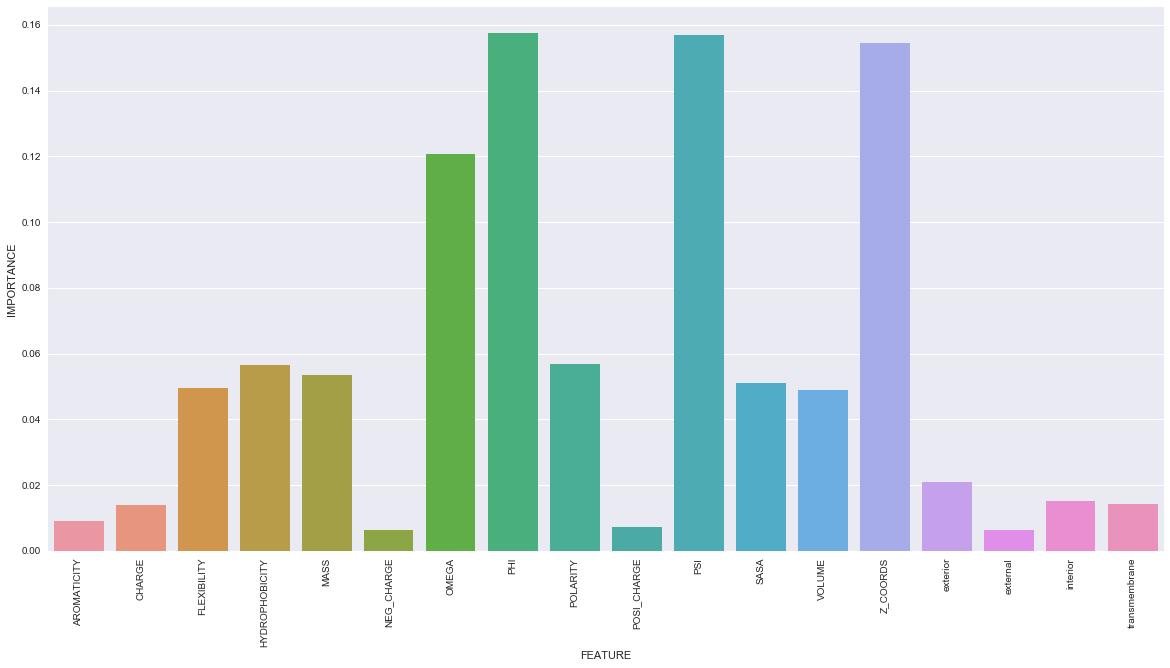

In [104]:
plot_feature_importances(barrel_feature_importances_2)

In [105]:
barrel_clf_2_predictions, barrel_clf_2_accuracy = calc_accuracy_r2(
    barrel_clf_2, accuracy_score, barrel_test_features_2, barrel_test_labels_2
)

In [106]:
print(barrel_clf_2_accuracy)

0.03656998738965952


There is little difference in accuracy when I use the physicochemical properties as opposed to the identities of an amino acid's neighbours to predict its identity.

So, how about predicting the properties of the (central) amino acid using the identities of its backbone hydrogen bonding partners?

In [107]:
barrel_fasta_mass = convert_aa_id_to_cont_property(
    barrel_df_filt['FASTA'].tolist(), mass_dict, 'FASTA_MASS', nested_list=False
)
barrel_fasta_hydrophobicity = convert_aa_id_to_cont_property(
    barrel_df_filt['FASTA'].tolist(), hydrophobicity_dict, 'FASTA_HYDROPHOBICITY', nested_list=False
)
barrel_fasta_volume = convert_aa_id_to_cont_property(
    barrel_df_filt['FASTA'].tolist(), side_chain_volume_dict, 'FASTA_VOLUME', nested_list=False
)
barrel_fasta_sasa = convert_aa_id_to_cont_property(
    barrel_df_filt['FASTA'].tolist(), side_chain_sasa, 'FASTA_SASA', nested_list=False
)
barrel_fasta_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['FASTA'].tolist(), charge_at_ph_7_dict, 'FASTA_CHARGE', nested_list=False
)
barrel_fasta_neg_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['FASTA'].tolist(), neg_charge_at_ph_7_dict, 'FASTA_NEG_CHARGE', nested_list=False
)
barrel_fasta_posi_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['FASTA'].tolist(), posi_charge_at_ph_7_dict, 'FASTA_POSI_CHARGE', nested_list=False
)
barrel_fasta_polarity = convert_aa_id_to_cont_property(
    barrel_df_filt['FASTA'].tolist(), polarity_dict, 'FASTA_POLARITY', nested_list=False
)
barrel_fasta_aromaticity = convert_aa_id_to_cont_property(
    barrel_df_filt['FASTA'].tolist(), aromaticity_dict, 'FASTA_AROMATICITY', nested_list=False
)
barrel_fasta_flexibility = convert_aa_id_to_cont_property(
    barrel_df_filt['FASTA'].tolist(), flexibility_dict, 'FASTA_FLEXIBILITY', nested_list=False
)

In [108]:
(barrel_train_features_3, barrel_test_features_3, barrel_train_labels_3, barrel_test_labels_3, barrel_feature_names_3,
 barrel_label_names_3) = gen_train_test_data(
    [barrel_int_ext, barrel_tm_ext, barrel_z, barrel_phi_psi_omega, barrel_backbone_h],
    [barrel_fasta_mass, barrel_fasta_hydrophobicity, barrel_fasta_volume, barrel_fasta_sasa, barrel_fasta_charge,
     barrel_fasta_posi_charge, barrel_fasta_neg_charge, barrel_fasta_polarity, barrel_fasta_aromaticity,
     barrel_fasta_flexibility],
    test_frac=0.25
)

In [109]:
barrel_reg_3 = RandomForestRegressor(
    n_estimators=10,
)
barrel_reg_3.fit(barrel_train_features_3, barrel_train_labels_3)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [110]:
barrel_feature_importances_3 = calc_feature_importances(barrel_reg_3, barrel_feature_names_3)

In [111]:
print(barrel_feature_importances_3)

           FEATURE  IMPORTANCE
0   BRIDGE_PAIRS_A    0.009916
1   BRIDGE_PAIRS_C    0.000075
2   BRIDGE_PAIRS_D    0.009070
3   BRIDGE_PAIRS_E    0.007636
4   BRIDGE_PAIRS_F    0.010670
5   BRIDGE_PAIRS_G    0.018610
6   BRIDGE_PAIRS_H    0.003296
7   BRIDGE_PAIRS_I    0.008597
8   BRIDGE_PAIRS_K    0.006836
9   BRIDGE_PAIRS_L    0.011240
10  BRIDGE_PAIRS_M    0.003836
11  BRIDGE_PAIRS_N    0.008505
12  BRIDGE_PAIRS_P    0.008574
13  BRIDGE_PAIRS_Q    0.007780
14  BRIDGE_PAIRS_R    0.008742
15  BRIDGE_PAIRS_S    0.012554
16  BRIDGE_PAIRS_T    0.010956
17  BRIDGE_PAIRS_V    0.009028
18  BRIDGE_PAIRS_W    0.008322
19  BRIDGE_PAIRS_Y    0.009551
20           OMEGA    0.133142
21             PHI    0.216498
22             PSI    0.266327
23        Z_COORDS    0.183645
24        exterior    0.015886
25        external    0.003085
26        interior    0.004550
27   transmembrane    0.003072


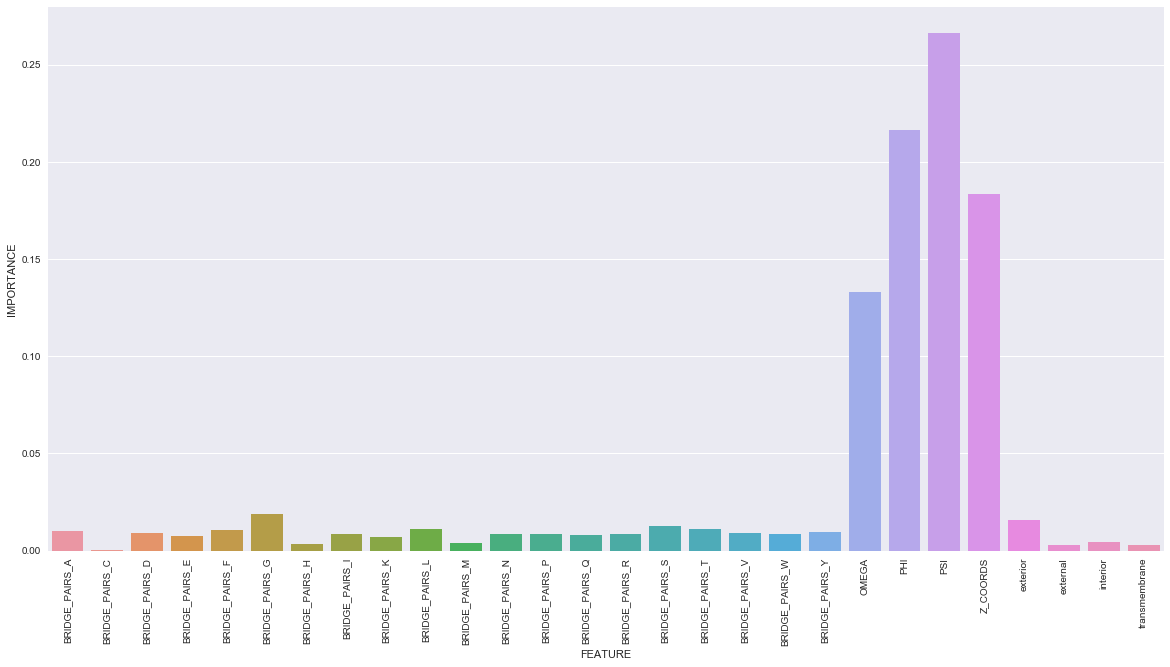

In [112]:
plot_feature_importances(barrel_feature_importances_3)

In [113]:
barrel_reg_3_predictions, barrel_reg_3_r2 = calc_accuracy_r2(
    barrel_reg_3, r2_score, barrel_test_features_3, barrel_test_labels_3
)

In [114]:
print(barrel_reg_3_r2)

0.08721388559130597


In comparison, if I use neighbouring amino acid properties to predict the properties of the central amino acid:

In [115]:
(barrel_train_features_4, barrel_test_features_4, barrel_train_labels_4, barrel_test_labels_4,
 barrel_feature_names_4, barrel_label_names_4) = gen_train_test_data(
    [barrel_int_ext, barrel_tm_ext, barrel_z, barrel_phi_psi_omega, barrel_backbone_h_mass,
     barrel_backbone_h_hydrophobicity, barrel_backbone_h_volumes, barrel_backbone_h_sasa,
     barrel_backbone_h_net_charge, barrel_backbone_h_posi_charge, barrel_backbone_h_neg_charge,
     barrel_backbone_h_polarity, barrel_backbone_h_aromaticity, barrel_backbone_h_flexibility],
    [barrel_fasta_mass, barrel_fasta_hydrophobicity, barrel_fasta_volume, barrel_fasta_sasa, barrel_fasta_charge,
     barrel_fasta_posi_charge, barrel_fasta_neg_charge, barrel_fasta_polarity, barrel_fasta_aromaticity,
     barrel_fasta_flexibility],
    test_frac=0.25
)

In [116]:
barrel_reg_4 = RandomForestRegressor(
    n_estimators=10,
)
barrel_reg_4.fit(barrel_train_features_4, barrel_train_labels_4)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [117]:
barrel_feature_importances_4 = calc_feature_importances(barrel_reg_4, barrel_feature_names_4)

In [118]:
barrel_feature_importances_4

,FEATURE,IMPORTANCE
0,AROMATICITY,0.007536
1,CHARGE,0.008682
2,FLEXIBILITY,0.027968
3,HYDROPHOBICITY,0.045544
4,MASS,0.032265
5,NEG_CHARGE,0.004424
6,OMEGA,0.124525
7,PHI,0.183855
8,POLARITY,0.051934
9,POSI_CHARGE,0.003190


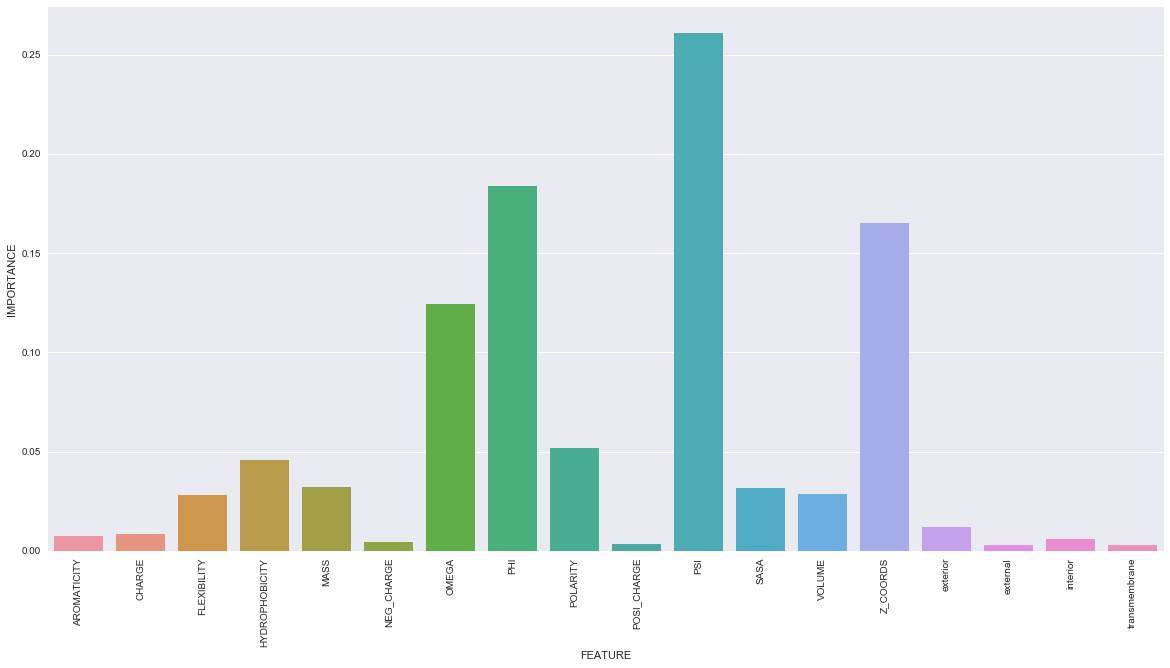

In [119]:
plot_feature_importances(barrel_feature_importances_4)

In [120]:
barrel_reg_4_predictions, barrel_reg_4_r2 = calc_accuracy_r2(
    barrel_reg_4, r2_score, barrel_test_features_4, barrel_test_labels_4
)

In [121]:
print(barrel_reg_4_r2)

0.0722470676656108


# Improved neighbouring amino acids information

Currently I provide information on backbone hydrogen bonding amino acids, and on all amino acids within a 5 Angstrom radius. Each do equally well - in the case of the backbone hydrogen bonding amino acids, only a fraction of the amino acids neighbouring a residue are beng considered, whereas in the case of the neighbouring amino acids, residues on different sheet surfaces and in different strands etc. are all weighted equally (thus introducing a lot of noise). So, I think I need to introduce information about neighbouring amino acids in a more intelligent way. Therefore, initially I will introduce information about the +/-1 and +/-2 amino acid identities in the strand.

In [122]:
barrel_minus_1_pos_mass = convert_aa_id_to_cont_property(
    barrel_df_filt['MINUS_1_POS'].tolist(), mass_dict, 'MINUS_1_POS_MASS', nested_list=False
)
barrel_minus_1_pos_hydrophobicity = convert_aa_id_to_cont_property(
    barrel_df_filt['MINUS_1_POS'].tolist(), hydrophobicity_dict, 'MINUS_1_POS_HYDROPHOBICITY', nested_list=False
)
barrel_minus_1_pos_volume = convert_aa_id_to_cont_property(
    barrel_df_filt['MINUS_1_POS'].tolist(), side_chain_volume_dict, 'MINUS_1_POS_VOLUME', nested_list=False
)
barrel_minus_1_pos_sasa = convert_aa_id_to_cont_property(
    barrel_df_filt['MINUS_1_POS'].tolist(), side_chain_sasa, 'MINUS_1_POS_SASA', nested_list=False
)
barrel_minus_1_pos_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['MINUS_1_POS'].tolist(), charge_at_ph_7_dict, 'MINUS_1_POS_CHARGE', nested_list=False
)
barrel_minus_1_pos_neg_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['MINUS_1_POS'].tolist(), neg_charge_at_ph_7_dict, 'MINUS_1_POS_NEG_CHARGE', nested_list=False
)
barrel_minus_1_pos_posi_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['MINUS_1_POS'].tolist(), posi_charge_at_ph_7_dict, 'MINUS_1_POS_POSI_CHARGE', nested_list=False
)
barrel_minus_1_pos_polarity = convert_aa_id_to_cont_property(
    barrel_df_filt['MINUS_1_POS'].tolist(), polarity_dict, 'MINUS_1_POS_POLARITY', nested_list=False
)
barrel_minus_1_pos_aromaticity = convert_aa_id_to_cont_property(
    barrel_df_filt['MINUS_1_POS'].tolist(), aromaticity_dict, 'MINUS_1_POS_AROMATICITY', nested_list=False
)
barrel_minus_1_pos_flexibility = convert_aa_id_to_cont_property(
    barrel_df_filt['MINUS_1_POS'].tolist(), flexibility_dict, 'MINUS_1_POS_FLEXIBILITY', nested_list=False
)

In [123]:
barrel_minus_2_pos_mass = convert_aa_id_to_cont_property(
    barrel_df_filt['MINUS_2_POS'].tolist(), mass_dict, 'MINUS_2_POS_MASS', nested_list=False
)
barrel_minus_2_pos_hydrophobicity = convert_aa_id_to_cont_property(
    barrel_df_filt['MINUS_2_POS'].tolist(), hydrophobicity_dict, 'MINUS_2_POS_HYDROPHOBICITY', nested_list=False
)
barrel_minus_2_pos_volume = convert_aa_id_to_cont_property(
    barrel_df_filt['MINUS_2_POS'].tolist(), side_chain_volume_dict, 'MINUS_2_POS_VOLUME', nested_list=False
)
barrel_minus_2_pos_sasa = convert_aa_id_to_cont_property(
    barrel_df_filt['MINUS_2_POS'].tolist(), side_chain_sasa, 'MINUS_2_POS_SASA', nested_list=False
)
barrel_minus_2_pos_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['MINUS_2_POS'].tolist(), charge_at_ph_7_dict, 'MINUS_2_POS_CHARGE', nested_list=False
)
barrel_minus_2_pos_neg_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['MINUS_2_POS'].tolist(), neg_charge_at_ph_7_dict, 'MINUS_2_POS_NEG_CHARGE', nested_list=False
)
barrel_minus_2_pos_posi_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['MINUS_2_POS'].tolist(), posi_charge_at_ph_7_dict, 'MINUS_2_POS_POSI_CHARGE', nested_list=False
)
barrel_minus_2_pos_polarity = convert_aa_id_to_cont_property(
    barrel_df_filt['MINUS_2_POS'].tolist(), polarity_dict, 'MINUS_2_POS_POLARITY', nested_list=False
)
barrel_minus_2_pos_aromaticity = convert_aa_id_to_cont_property(
    barrel_df_filt['MINUS_2_POS'].tolist(), aromaticity_dict, 'MINUS_2_POS_AROMATICITY', nested_list=False
)
barrel_minus_2_pos_flexibility = convert_aa_id_to_cont_property(
    barrel_df_filt['MINUS_2_POS'].tolist(), flexibility_dict, 'MINUS_2_POS_FLEXIBILITY', nested_list=False
)

In [124]:
barrel_plus_1_pos_mass = convert_aa_id_to_cont_property(
    barrel_df_filt['PLUS_1_POS'].tolist(), mass_dict, 'PLUS_1_POS_MASS', nested_list=False
)
barrel_plus_1_pos_hydrophobicity = convert_aa_id_to_cont_property(
    barrel_df_filt['PLUS_1_POS'].tolist(), hydrophobicity_dict, 'PLUS_1_POS_HYDROPHOBICITY', nested_list=False
)
barrel_plus_1_pos_volume = convert_aa_id_to_cont_property(
    barrel_df_filt['PLUS_1_POS'].tolist(), side_chain_volume_dict, 'PLUS_1_POS_VOLUME', nested_list=False
)
barrel_plus_1_pos_sasa = convert_aa_id_to_cont_property(
    barrel_df_filt['PLUS_1_POS'].tolist(), side_chain_sasa, 'PLUS_1_POS_SASA', nested_list=False
)
barrel_plus_1_pos_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['PLUS_1_POS'].tolist(), charge_at_ph_7_dict, 'PLUS_1_POS_CHARGE', nested_list=False
)
barrel_plus_1_pos_neg_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['PLUS_1_POS'].tolist(), neg_charge_at_ph_7_dict, 'PLUS_1_POS_NEG_CHARGE', nested_list=False
)
barrel_plus_1_pos_posi_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['PLUS_1_POS'].tolist(), posi_charge_at_ph_7_dict, 'PLUS_1_POS_POSI_CHARGE', nested_list=False
)
barrel_plus_1_pos_polarity = convert_aa_id_to_cont_property(
    barrel_df_filt['PLUS_1_POS'].tolist(), polarity_dict, 'PLUS_1_POS_POLARITY', nested_list=False
)
barrel_plus_1_pos_aromaticity = convert_aa_id_to_cont_property(
    barrel_df_filt['PLUS_1_POS'].tolist(), aromaticity_dict, 'PLUS_1_POS_AROMATICITY', nested_list=False
)
barrel_plus_1_pos_flexibility = convert_aa_id_to_cont_property(
    barrel_df_filt['PLUS_1_POS'].tolist(), flexibility_dict, 'PLUS_1_POS_FLEXIBILITY', nested_list=False
)

In [125]:
barrel_plus_2_pos_mass = convert_aa_id_to_cont_property(
    barrel_df_filt['PLUS_2_POS'].tolist(), mass_dict, 'PLUS_2_POS_MASS', nested_list=False
)
barrel_plus_2_pos_hydrophobicity = convert_aa_id_to_cont_property(
    barrel_df_filt['PLUS_2_POS'].tolist(), hydrophobicity_dict, 'PLUS_2_POS_HYDROPHOBICITY', nested_list=False
)
barrel_plus_2_pos_volume = convert_aa_id_to_cont_property(
    barrel_df_filt['PLUS_2_POS'].tolist(), side_chain_volume_dict, 'PLUS_2_POS_VOLUME', nested_list=False
)
barrel_plus_2_pos_sasa = convert_aa_id_to_cont_property(
    barrel_df_filt['PLUS_2_POS'].tolist(), side_chain_sasa, 'PLUS_2_POS_SASA', nested_list=False
)
barrel_plus_2_pos_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['PLUS_2_POS'].tolist(), charge_at_ph_7_dict, 'PLUS_2_POS_CHARGE', nested_list=False
)
barrel_plus_2_pos_neg_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['PLUS_2_POS'].tolist(), neg_charge_at_ph_7_dict, 'PLUS_2_POS_NEG_CHARGE', nested_list=False
)
barrel_plus_2_pos_posi_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['PLUS_2_POS'].tolist(), posi_charge_at_ph_7_dict, 'PLUS_2_POS_POSI_CHARGE', nested_list=False
)
barrel_plus_2_pos_polarity = convert_aa_id_to_cont_property(
    barrel_df_filt['PLUS_2_POS'].tolist(), polarity_dict, 'PLUS_2_POS_POLARITY', nested_list=False
)
barrel_plus_2_pos_aromaticity = convert_aa_id_to_cont_property(
    barrel_df_filt['PLUS_2_POS'].tolist(), aromaticity_dict, 'PLUS_2_POS_AROMATICITY', nested_list=False
)
barrel_plus_2_pos_flexibility = convert_aa_id_to_cont_property(
    barrel_df_filt['PLUS_2_POS'].tolist(), flexibility_dict, 'PLUS_2_POS_FLEXIBILITY', nested_list=False
)

In [133]:
barrel_vdw_mass = convert_aa_id_to_cont_property(
    barrel_df_filt['VDW_FASTA'].tolist(), mass_dict, 'VDW_FASTA_MASS', nested_list=True
)
barrel_vdw_hydrophobicity = convert_aa_id_to_cont_property(
    barrel_df_filt['VDW_FASTA'].tolist(), hydrophobicity_dict, 'VDW_FASTA_HYDROPHOBICITY', nested_list=True
)
barrel_vdw_volume = convert_aa_id_to_cont_property(
    barrel_df_filt['VDW_FASTA'].tolist(), side_chain_volume_dict, 'VDW_FASTA_VOLUME', nested_list=True
)
barrel_vdw_sasa = convert_aa_id_to_cont_property(
    barrel_df_filt['VDW_FASTA'].tolist(), side_chain_sasa, 'VDW_FASTA_SASA', nested_list=True
)
barrel_vdw_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['VDW_FASTA'].tolist(), charge_at_ph_7_dict, 'VDW_FASTA_CHARGE', nested_list=True
)
barrel_vdw_neg_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['VDW_FASTA'].tolist(), neg_charge_at_ph_7_dict, 'VDW_FASTA_NEG_CHARGE', nested_list=True
)
barrel_vdw_posi_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['VDW_FASTA'].tolist(), posi_charge_at_ph_7_dict, 'VDW_FASTA_POSI_CHARGE', nested_list=True
)
barrel_vdw_polarity = convert_aa_id_to_cont_property(
    barrel_df_filt['VDW_FASTA'].tolist(), polarity_dict, 'VDW_FASTA_POLARITY', nested_list=True
)
barrel_vdw_aromaticity = convert_aa_id_to_cont_property(
    barrel_df_filt['VDW_FASTA'].tolist(), aromaticity_dict, 'VDW_FASTA_AROMATICITY', nested_list=True
)
barrel_vdw_flexibility = convert_aa_id_to_cont_property(
    barrel_df_filt['VDW_FASTA'].tolist(), flexibility_dict, 'VDW_FASTA_FLEXIBILITY', nested_list=True
)

In [134]:
barrel_ionic_mass = convert_aa_id_to_cont_property(
    barrel_df_filt['IONIC_FASTA'].tolist(), mass_dict, 'IONIC_FASTA_MASS', nested_list=True
)
barrel_ionic_hydrophobicity = convert_aa_id_to_cont_property(
    barrel_df_filt['IONIC_FASTA'].tolist(), hydrophobicity_dict, 'IONIC_FASTA_HYDROPHOBICITY', nested_list=True
)
barrel_ionic_volume = convert_aa_id_to_cont_property(
    barrel_df_filt['IONIC_FASTA'].tolist(), side_chain_volume_dict, 'IONIC_FASTA_VOLUME', nested_list=True
)
barrel_ionic_sasa = convert_aa_id_to_cont_property(
    barrel_df_filt['IONIC_FASTA'].tolist(), side_chain_sasa, 'IONIC_FASTA_SASA', nested_list=True
)
barrel_ionic_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['IONIC_FASTA'].tolist(), charge_at_ph_7_dict, 'IONIC_FASTA_CHARGE', nested_list=True
)
barrel_ionic_neg_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['IONIC_FASTA'].tolist(), neg_charge_at_ph_7_dict, 'IONIC_FASTA_NEG_CHARGE', nested_list=True
)
barrel_ionic_posi_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['IONIC_FASTA'].tolist(), posi_charge_at_ph_7_dict, 'IONIC_FASTA_POSI_CHARGE', nested_list=True
)
barrel_ionic_polarity = convert_aa_id_to_cont_property(
    barrel_df_filt['IONIC_FASTA'].tolist(), polarity_dict, 'IONIC_FASTA_POLARITY', nested_list=True
)
barrel_ionic_aromaticity = convert_aa_id_to_cont_property(
    barrel_df_filt['IONIC_FASTA'].tolist(), aromaticity_dict, 'IONIC_FASTA_AROMATICITY', nested_list=True
)
barrel_ionic_flexibility = convert_aa_id_to_cont_property(
    barrel_df_filt['IONIC_FASTA'].tolist(), flexibility_dict, 'IONIC_FASTA_FLEXIBILITY', nested_list=True
)

In [140]:
barrel_ssbond_mass = convert_aa_id_to_cont_property(
    barrel_df_filt['SSBOND_FASTA'].tolist(), mass_dict, 'SSBOND_FASTA_MASS', nested_list=True
)
barrel_ssbond_hydrophobicity = convert_aa_id_to_cont_property(
    barrel_df_filt['SSBOND_FASTA'].tolist(), hydrophobicity_dict, 'SSBOND_FASTA_HYDROPHOBICITY', nested_list=True
)
barrel_ssbond_volume = convert_aa_id_to_cont_property(
    barrel_df_filt['SSBOND_FASTA'].tolist(), side_chain_volume_dict, 'SSBOND_FASTA_VOLUME', nested_list=True
)
barrel_ssbond_sasa = convert_aa_id_to_cont_property(
    barrel_df_filt['SSBOND_FASTA'].tolist(), side_chain_sasa, 'SSBOND_FASTA_SASA', nested_list=True
)
barrel_ssbond_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['SSBOND_FASTA'].tolist(), charge_at_ph_7_dict, 'SSBOND_FASTA_CHARGE', nested_list=True
)
barrel_ssbond_neg_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['SSBOND_FASTA'].tolist(), neg_charge_at_ph_7_dict, 'SSBOND_FASTA_NEG_CHARGE', nested_list=True
)
barrel_ssbond_posi_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['SSBOND_FASTA'].tolist(), posi_charge_at_ph_7_dict, 'SSBOND_FASTA_POSI_CHARGE', nested_list=True
)
barrel_ssbond_polarity = convert_aa_id_to_cont_property(
    barrel_df_filt['SSBOND_FASTA'].tolist(), polarity_dict, 'SSBOND_FASTA_POLARITY', nested_list=True
)
barrel_ssbond_aromaticity = convert_aa_id_to_cont_property(
    barrel_df_filt['SSBOND_FASTA'].tolist(), aromaticity_dict, 'SSBOND_FASTA_AROMATICITY', nested_list=True
)
barrel_ssbond_flexibility = convert_aa_id_to_cont_property(
    barrel_df_filt['SSBOND_FASTA'].tolist(), flexibility_dict, 'SSBOND_FASTA_FLEXIBILITY', nested_list=True
)

In [135]:
barrel_pication_mass = convert_aa_id_to_cont_property(
    barrel_df_filt['PICATION_FASTA'].tolist(), mass_dict, 'PICATION_FASTA_MASS', nested_list=True
)
barrel_pication_hydrophobicity = convert_aa_id_to_cont_property(
    barrel_df_filt['PICATION_FASTA'].tolist(), hydrophobicity_dict, 'PICATION_FASTA_HYDROPHOBICITY', nested_list=True
)
barrel_pication_volume = convert_aa_id_to_cont_property(
    barrel_df_filt['PICATION_FASTA'].tolist(), side_chain_volume_dict, 'PICATION_FASTA_VOLUME', nested_list=True
)
barrel_pication_sasa = convert_aa_id_to_cont_property(
    barrel_df_filt['PICATION_FASTA'].tolist(), side_chain_sasa, 'PICATION_FASTA_SASA', nested_list=True
)
barrel_pication_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['PICATION_FASTA'].tolist(), charge_at_ph_7_dict, 'PICATION_FASTA_CHARGE', nested_list=True
)
barrel_pication_neg_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['PICATION_FASTA'].tolist(), neg_charge_at_ph_7_dict, 'PICATION_FASTA_NEG_CHARGE', nested_list=True
)
barrel_pication_posi_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['PICATION_FASTA'].tolist(), posi_charge_at_ph_7_dict, 'PICATION_FASTA_POSI_CHARGE', nested_list=True
)
barrel_pication_polarity = convert_aa_id_to_cont_property(
    barrel_df_filt['PICATION_FASTA'].tolist(), polarity_dict, 'PICATION_FASTA_POLARITY', nested_list=True
)
barrel_pication_aromaticity = convert_aa_id_to_cont_property(
    barrel_df_filt['PICATION_FASTA'].tolist(), aromaticity_dict, 'PICATION_FASTA_AROMATICITY', nested_list=True
)
barrel_pication_flexibility = convert_aa_id_to_cont_property(
    barrel_df_filt['PICATION_FASTA'].tolist(), flexibility_dict, 'PICATION_FASTA_FLEXIBILITY', nested_list=True
)

In [137]:
barrel_pipistack_mass = convert_aa_id_to_cont_property(
    barrel_df_filt['PIPISTACK_FASTA'].tolist(), mass_dict, 'PIPISTACKING_FASTA_MASS', nested_list=True
)
barrel_pipistack_hydrophobicity = convert_aa_id_to_cont_property(
    barrel_df_filt['PIPISTACK_FASTA'].tolist(), hydrophobicity_dict, 'PIPISTACKING_FASTA_HYDROPHOBICITY', nested_list=True
)
barrel_pipistack_volume = convert_aa_id_to_cont_property(
    barrel_df_filt['PIPISTACK_FASTA'].tolist(), side_chain_volume_dict, 'PIPISTACKING_FASTA_VOLUME', nested_list=True
)
barrel_pipistack_sasa = convert_aa_id_to_cont_property(
    barrel_df_filt['PIPISTACK_FASTA'].tolist(), side_chain_sasa, 'PIPISTACKING_FASTA_SASA', nested_list=True
)
barrel_pipistack_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['PIPISTACK_FASTA'].tolist(), charge_at_ph_7_dict, 'PIPISTACKING_FASTA_CHARGE', nested_list=True
)
barrel_pipistack_neg_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['PIPISTACK_FASTA'].tolist(), neg_charge_at_ph_7_dict, 'PIPISTACKING_FASTA_NEG_CHARGE', nested_list=True
)
barrel_pipistack_posi_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['PIPISTACK_FASTA'].tolist(), posi_charge_at_ph_7_dict, 'PIPISTACKING_FASTA_POSI_CHARGE', nested_list=True
)
barrel_pipistack_polarity = convert_aa_id_to_cont_property(
    barrel_df_filt['PIPISTACK_FASTA'].tolist(), polarity_dict, 'PIPISTACKING_FASTA_POLARITY', nested_list=True
)
barrel_pipistack_aromaticity = convert_aa_id_to_cont_property(
    barrel_df_filt['PIPISTACK_FASTA'].tolist(), aromaticity_dict, 'PIPISTACKING_FASTA_AROMATICITY', nested_list=True
)
barrel_pipistack_flexibility = convert_aa_id_to_cont_property(
    barrel_df_filt['PIPISTACK_FASTA'].tolist(), flexibility_dict, 'PIPISTACKING_FASTA_FLEXIBILITY', nested_list=True
)

In [138]:
barrel_hbond_mass = convert_aa_id_to_cont_property(
    barrel_df_filt['HBOND_FASTA'].tolist(), mass_dict, 'HBOND_FASTA_MASS', nested_list=True
)
barrel_hbond_hydrophobicity = convert_aa_id_to_cont_property(
    barrel_df_filt['HBOND_FASTA'].tolist(), hydrophobicity_dict, 'HBOND_FASTA_HYDROPHOBICITY', nested_list=True
)
barrel_hbond_volume = convert_aa_id_to_cont_property(
    barrel_df_filt['HBOND_FASTA'].tolist(), side_chain_volume_dict, 'HBOND_FASTA_VOLUME', nested_list=True
)
barrel_hbond_sasa = convert_aa_id_to_cont_property(
    barrel_df_filt['HBOND_FASTA'].tolist(), side_chain_sasa, 'HBOND_FASTA_SASA', nested_list=True
)
barrel_hbond_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['HBOND_FASTA'].tolist(), charge_at_ph_7_dict, 'HBOND_FASTA_CHARGE', nested_list=True
)
barrel_hbond_neg_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['HBOND_FASTA'].tolist(), neg_charge_at_ph_7_dict, 'HBOND_FASTA_NEG_CHARGE', nested_list=True
)
barrel_hbond_posi_charge = convert_aa_id_to_cont_property(
    barrel_df_filt['HBOND_FASTA'].tolist(), posi_charge_at_ph_7_dict, 'HBOND_FASTA_POSI_CHARGE', nested_list=True
)
barrel_hbond_polarity = convert_aa_id_to_cont_property(
    barrel_df_filt['HBOND_FASTA'].tolist(), polarity_dict, 'HBOND_FASTA_POLARITY', nested_list=True
)
barrel_hbond_aromaticity = convert_aa_id_to_cont_property(
    barrel_df_filt['HBOND_FASTA'].tolist(), aromaticity_dict, 'HBOND_FASTA_AROMATICITY', nested_list=True
)
barrel_hbond_flexibility = convert_aa_id_to_cont_property(
    barrel_df_filt['HBOND_FASTA'].tolist(), flexibility_dict, 'HBOND_FASTA_FLEXIBILITY', nested_list=True
)

In [420]:
(barrel_train_features_5, barrel_test_features_5, barrel_train_labels_5, barrel_test_labels_5,
 barrel_feature_names_5, barrel_label_names_5) = gen_train_test_data(
    [barrel_int_ext, barrel_tm_ext, barrel_z, barrel_minus_1_pos_mass,
     barrel_minus_1_pos_hydrophobicity, barrel_minus_1_pos_volume, barrel_minus_1_pos_sasa,
     barrel_minus_1_pos_charge, barrel_minus_1_pos_neg_charge, barrel_minus_1_pos_posi_charge,
     barrel_minus_1_pos_polarity, barrel_minus_1_pos_aromaticity, barrel_minus_1_pos_flexibility,
     barrel_minus_2_pos_mass, barrel_minus_2_pos_hydrophobicity, barrel_minus_2_pos_volume,
     barrel_minus_2_pos_sasa, barrel_minus_2_pos_charge, barrel_minus_2_pos_neg_charge,
     barrel_minus_2_pos_posi_charge, barrel_minus_2_pos_polarity, barrel_minus_2_pos_aromaticity,
     barrel_minus_2_pos_flexibility, barrel_plus_1_pos_mass, barrel_plus_1_pos_hydrophobicity,
     barrel_plus_1_pos_volume, barrel_plus_1_pos_sasa, barrel_plus_1_pos_charge,
     barrel_plus_1_pos_neg_charge, barrel_plus_1_pos_posi_charge, barrel_plus_1_pos_polarity,
     barrel_plus_1_pos_aromaticity, barrel_plus_1_pos_flexibility, barrel_plus_2_pos_mass,
     barrel_plus_2_pos_hydrophobicity, barrel_plus_2_pos_volume, barrel_plus_2_pos_sasa,
     barrel_plus_2_pos_charge, barrel_plus_2_pos_neg_charge, barrel_plus_2_pos_posi_charge,
     barrel_plus_2_pos_polarity, barrel_plus_2_pos_aromaticity, barrel_plus_2_pos_flexibility,
     barrel_vdw_mass, barrel_vdw_hydrophobicity, barrel_vdw_volume, barrel_vdw_sasa, barrel_vdw_charge,
     barrel_vdw_neg_charge, barrel_vdw_posi_charge, barrel_vdw_polarity, barrel_vdw_aromaticity,
     barrel_vdw_flexibility, barrel_ionic_mass, barrel_ionic_hydrophobicity, barrel_ionic_volume,
     barrel_ionic_sasa, barrel_ionic_charge, barrel_ionic_neg_charge, barrel_ionic_posi_charge,
     barrel_ionic_polarity, barrel_ionic_aromaticity, barrel_ionic_flexibility, barrel_ssbond_mass,
     barrel_ssbond_hydrophobicity, barrel_ssbond_volume, barrel_ssbond_sasa, barrel_ssbond_charge,
     barrel_ssbond_neg_charge, barrel_ssbond_posi_charge, barrel_ssbond_polarity, barrel_ssbond_aromaticity,
     barrel_ssbond_flexibility, barrel_pication_mass, barrel_pication_hydrophobicity, barrel_pication_volume,
     barrel_pication_sasa, barrel_pication_charge, barrel_pication_neg_charge, barrel_pication_posi_charge,
     barrel_pication_polarity, barrel_pication_aromaticity, barrel_pication_flexibility, barrel_pipistack_mass,
     barrel_pipistack_hydrophobicity, barrel_pipistack_volume, barrel_pipistack_sasa, barrel_pipistack_charge,
     barrel_pipistack_neg_charge, barrel_pipistack_posi_charge, barrel_pipistack_polarity,
     barrel_pipistack_aromaticity, barrel_pipistack_flexibility, barrel_hbond_mass,
     barrel_hbond_hydrophobicity, barrel_hbond_volume, barrel_hbond_sasa, barrel_hbond_charge,
     barrel_hbond_neg_charge, barrel_hbond_posi_charge, barrel_hbond_polarity, barrel_hbond_aromaticity,
     barrel_hbond_flexibility],
    [barrel_fasta_mass, barrel_fasta_hydrophobicity, barrel_fasta_volume, barrel_fasta_sasa, barrel_fasta_charge,
     barrel_fasta_posi_charge, barrel_fasta_neg_charge, barrel_fasta_polarity, barrel_fasta_aromaticity,
     barrel_fasta_flexibility],
    test_frac=0.25
)

In [421]:
barrel_reg_5 = RandomForestRegressor(
    n_estimators=10,
)
barrel_reg_5.fit(barrel_train_features_5, barrel_train_labels_5)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [422]:
barrel_feature_importances_5 = calc_feature_importances(barrel_reg_5, barrel_feature_names_5)

In [423]:
barrel_feature_importances_5

,FEATURE,IMPORTANCE
0,HBOND_FASTA_AROMATICITY,0.010272
1,HBOND_FASTA_CHARGE,0.006545
2,HBOND_FASTA_FLEXIBILITY,0.011597
3,HBOND_FASTA_HYDROPHOBICITY,0.022095
4,HBOND_FASTA_MASS,0.013745
5,HBOND_FASTA_NEG_CHARGE,0.004795
6,HBOND_FASTA_POLARITY,0.023516
7,HBOND_FASTA_POSI_CHARGE,0.003592
8,HBOND_FASTA_SASA,0.014912
9,HBOND_FASTA_VOLUME,0.014274


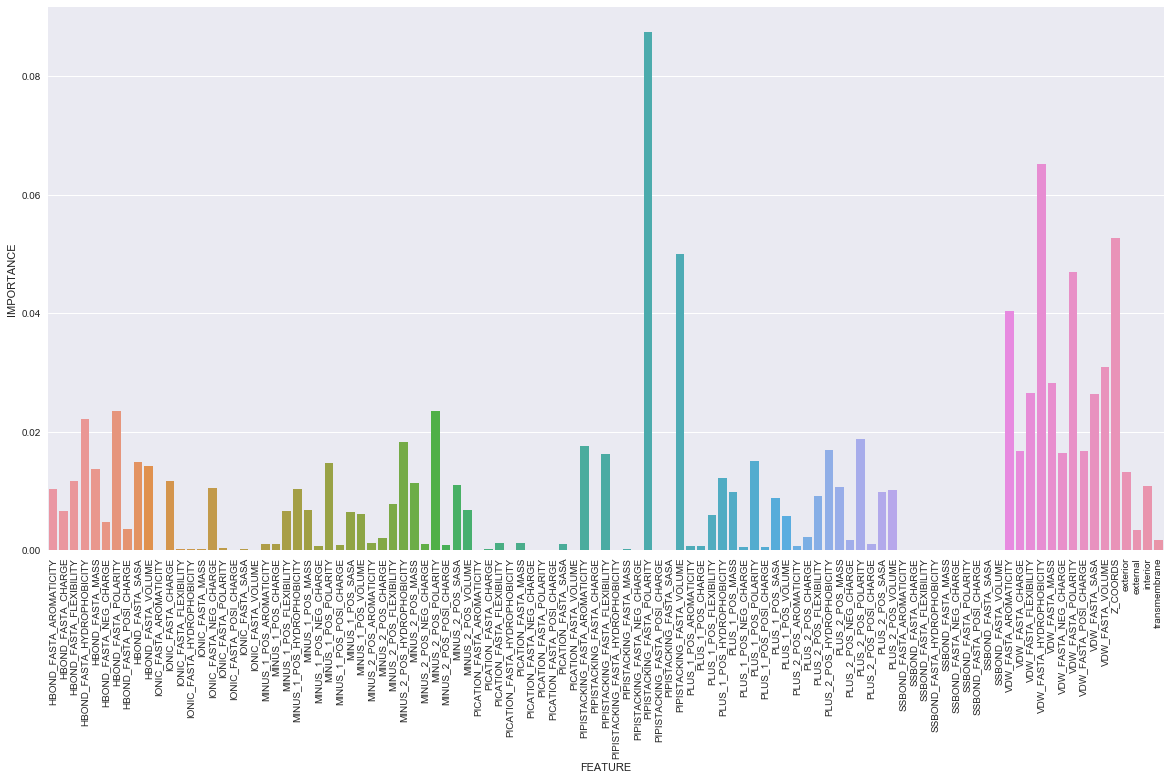

In [424]:
plot_feature_importances(barrel_feature_importances_5)

In [425]:
barrel_reg_5_predictions, barrel_reg_5_r2 = calc_accuracy_r2(
    barrel_reg_5, r2_score, barrel_test_features_5, barrel_test_labels_5
)

In [426]:
print(barrel_reg_5_r2)

0.2341264444226574


In [427]:
barrel_test_labels_5.columns

Index(['FASTA_AROMATICITY', 'FASTA_CHARGE', 'FASTA_FLEXIBILITY',
       'FASTA_HYDROPHOBICITY', 'FASTA_MASS', 'FASTA_NEG_CHARGE',
       'FASTA_POLARITY', 'FASTA_POSI_CHARGE', 'FASTA_SASA', 'FASTA_VOLUME'],
      dtype='object')

FASTA_AROMATICITY


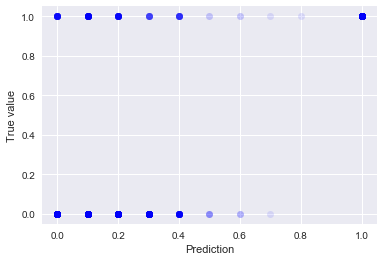

FASTA_CHARGE


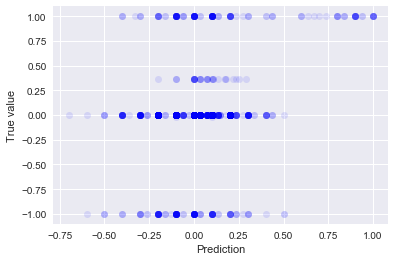

FASTA_FLEXIBILITY


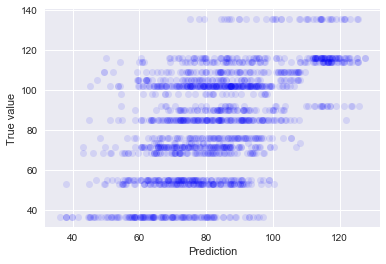

FASTA_HYDROPHOBICITY


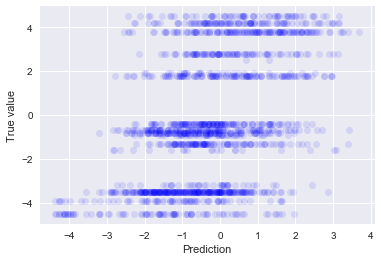

FASTA_MASS


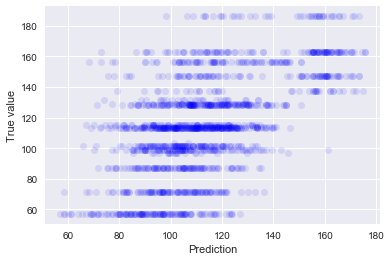

FASTA_NEG_CHARGE


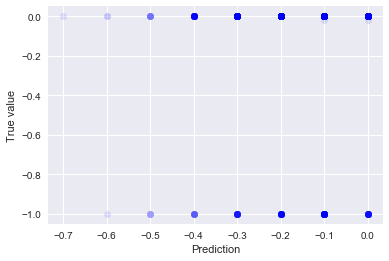

FASTA_POLARITY


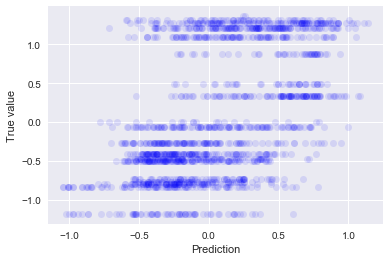

FASTA_POSI_CHARGE


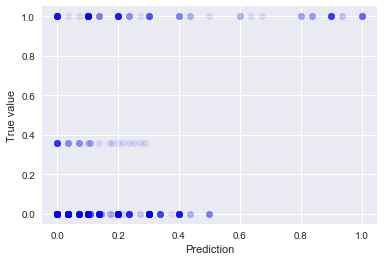

FASTA_SASA


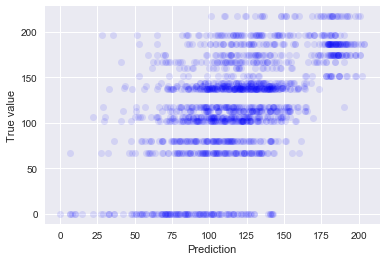

FASTA_VOLUME


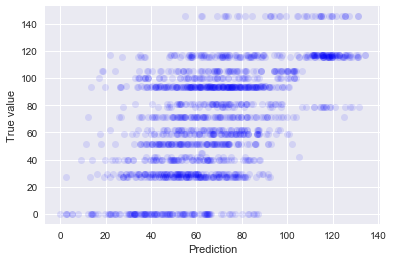

In [428]:
properties = ['FASTA_AROMATICITY', 'FASTA_CHARGE', 'FASTA_FLEXIBILITY', 'FASTA_HYDROPHOBICITY', 'FASTA_MASS',
              'FASTA_NEG_CHARGE', 'FASTA_POLARITY', 'FASTA_POSI_CHARGE', 'FASTA_SASA', 'FASTA_VOLUME']
for num in range(10):
    # print(len(barrel_reg_5_predictions[:, num].tolist()))
    # print(len(barrel_test_labels_5[properties[num]].tolist()))
    print(properties[num])
    plt.plot(barrel_reg_5_predictions[:, num].tolist(), barrel_test_labels_5[properties[num]].tolist(), 'bo',
             alpha=0.1)
    plt.xlabel('Prediction')
    plt.ylabel('True value')
    plt.show()

In [390]:
barrel_df_filt['FASTA'][3702]

'Y'

In [384]:
barrel_test_labels_5

,FASTA_AROMATICITY,FASTA_FLEXIBILITY,FASTA_HYDROPHOBICITY,FASTA_MASS,FASTA_SASA,FASTA_VOLUME
3811,0,71.2,-0.7,101.1051,102,51.3
2058,0,71.2,-0.7,101.1051,102,51.3
658,0,84.7,-3.5,129.1155,138,62.0
6126,0,109.1,-4.5,156.1876,196,105.0
5908,0,85.1,4.2,99.1326,117,71.5
4346,0,85.1,4.2,99.1326,117,71.5
3702,1,116.2,-1.3,163.1760,187,117.3
846,0,105.1,-3.9,128.1742,167,100.0
3822,0,102.0,3.8,113.1595,137,93.5
1162,0,85.1,4.2,99.1326,117,71.5


# Analysis of important features identified random forest classifier

### Beta_barrels

In [ ]:
plt.figure(figsize=(20, 10))
sns.swarmplot(x=barrel_df_filt['FASTA'], y=barrel_df_filt['PHI'])
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
sns.swarmplot(x=barrel_df_filt['FASTA'], y=barrel_df_filt['PSI'])
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
sns.swarmplot(x=barrel_df_filt['FASTA'], y=barrel_df_filt['OMEGA'])
plt.show()

In [ ]:
heatmap_array = pd.DataFrame(0, index=list(aa_dict.keys()), columns=list(aa_dict.keys()))

for row in range(barrel_df_filt.shape[0]):
    aa_1 = barrel_df_filt['FASTA'][row]
    for aa_2 in list(neighbours_dict.keys()):
        heatmap_array[aa_1][aa_2] += neighbours_dict[aa_2][row]
        
print(heatmap_array)

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(heatmap_array)
plt.show()